In [44]:
#Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras import layers, optimizers, regularizers
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
import sys, os
sys.path.append( os.path.abspath('../'))

%load_ext autoreload 
%autoreload 2

import custom_functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)
    
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)
    
    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None, 
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d", 
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")
    
    # Create a confusion matrix with the data with normalize argument 
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap, 
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")
    
    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()
    
    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

def evaluate_classification_network(model, 
                                    X_train=None, y_train=None, 
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f", 
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset
    
    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))
    
    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)
        
        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred, 
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')
        
        ## Run model.evaluate         
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))
      
    # If no X_test, then save empty list for results_test
    else:
        results_test = []
      
    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics 
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])
    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()
    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):
        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]
        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass
        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)
    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y
        
    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")   
        return np.argmax(y, axis=1)
    
    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []
    
    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():
        
        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    
    return y_true, y_pred_probs



In [3]:
# Loading Data
df = pd.read_csv("Data/spooky.csv", index_col = 'id')
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
#Making length column for text
df['length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()

,text,author,length
id,,,
id26305,"This process, however, afforded me no means of...",EAP,41
id17569,It never once occurred to me that the fumbling...,HPL,14
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
id27763,How lovely is spring As we looked from Windsor...,MWS,34
id12958,"Finding nothing else, not even gold, the Super...",HPL,27


In [5]:
df['length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: length, dtype: float64

- The range of sequence length is from 2 to 861.
- The average sequence length is around 26 words

In [6]:
df['author'].value_counts(normalize = True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

In [7]:
#RUS to match minority group
sampler = RandomUnderSampler(random_state=42)
df,  _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [8]:
#Crating map for targets
target_map = {'EAP':0,
             'HPL':1,
             'MWS':2}
y = df['author'].map(target_map)
y

id
id22483    0
id18809    0
id16322    0
id13423    0
id09553    0
          ..
id22356    2
id11504    2
id00149    2
id16796    2
id23776    2
Name: author, Length: 16905, dtype: int64

In [9]:
# X and y
X = df['text'].values
X

array(['He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.',
       'Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.',
       'The cold was intense, and obliged me to wrap up closely in an overcoat.',
       ...,
       'What I ask of you is reasonable and moderate; I demand a creature of another sex, but as hideous as myself; the gratification is small, but it is all that I can receive, and it shall content me.',
       'The birth of her daughter, embryo copy of her Raymond, filled up the measure of her content, and produced a sacred and indissoluble tie between them.',
       "I heard my sister's sobs, and thought, happy are women who can weep, and in a passionate caress disburthen the oppression of their feelings; shame and habitual restraint hold back a man."],
      dtype=object)

In [10]:
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [11]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

In [12]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32


import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [13]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [14]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


In [15]:
SEQUENCE_LENGTH = 100
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(standardize="lower_and_strip_punctuation",
                                                        output_mode="int",
                                                        output_sequence_length=SEQUENCE_LENGTH)

In [16]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'To look at a star by glances to view it in a side long way, by turning toward it the exterior portions of the retina more susceptible of feeble impressions of light than the interior, is to behold the star distinctly is to have the best appreciation of its lustre a lustre which grows dim just in proportion as we turn our vision fully upon it.',
       b'But, at this period, the whole scheme of my existence was about to change.',
       b"The frauds of the banks of course I couldn't help.",
       b'Once, overcome by fatigue, I sunk on the wet earth; about two hundred yards distant, alone in a large meadow stood a magnificent oak; the lightnings shewed its myriad boughs torn by the storm.',
       b"Encouraged by this encomium, I proceeded, in answer to his inquiries, to relate what I remembered of my parent; and he gave an account of those circumstances which had brought about a neglect of my father's testamentary letter.",
       

In [17]:
# Train (adapt on training text data))
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

20835

In [36]:
def build_gru_model(text_vectorization_layer):
    VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    EMBED_DIM = 150
                
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    # Output layer
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

In [25]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_4 (Embedding)     (None, 100, 150)          3125250   
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,233,157
Trainable params: 3,233,157
No

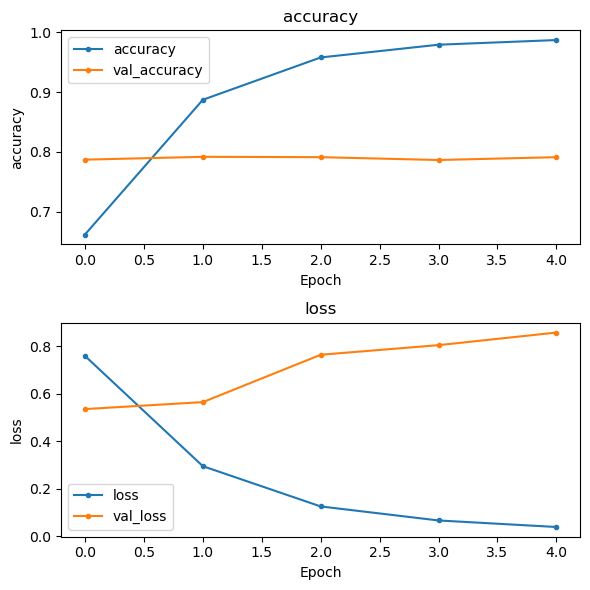


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3945
           1       1.00      0.99      1.00      3926
           2       1.00      1.00      1.00      3962

    accuracy                           1.00     11833
   macro avg       1.00      1.00      1.00     11833
weighted avg       1.00      1.00      1.00     11833



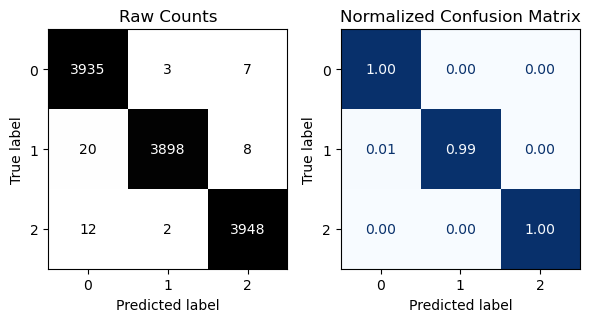


- Evaluating Training Data:
370/370 [==============================] - 3s 8ms/step - loss: 0.0152 - accuracy: 0.9956
{'loss': 0.015215640887618065, 'accuracy': 0.9956055283546448}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       568
           1       0.89      0.78      0.83       576
           2       0.80      0.82      0.81       547

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



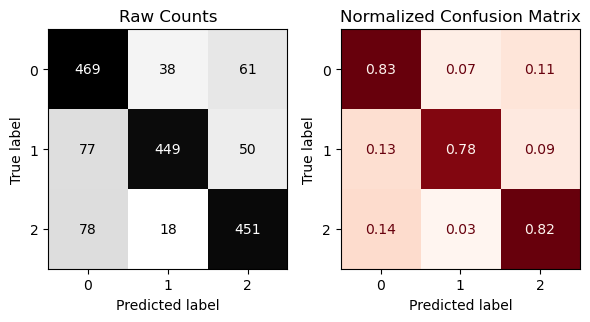


- Evaluating Test Data:
53/53 [==============================] - 0s 8ms/step - loss: 0.8039 - accuracy: 0.8096
{'loss': 0.8038789629936218, 'accuracy': 0.8095801472663879}


In [33]:
# Build the model
model = build_gru_model(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

In [55]:
def build_gru_model2(text_vectorization_layer):
    VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
    SEQUENCE_LENGTH = sequence_vectorizer.get_config()['output_sequence_length']
    EMBED_DIM = 150
    
    gru_model = Sequential([
        text_vectorization_layer,
        tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, 
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)])
    # Add GRU layer *new*
    gru_model.add(layers.GRU(128, recurrent_dropout=.2, dropout=.2, return_sequences = True))   
    gru_model.add(layers.GlobalMaxPooling1D())
    gru_model.add(layers.Dense(len(classes), 
                              activation='softmax'))
        
    optimizer = optimizers.legacy.Adam()
    gru_model.compile(optimizer=optimizer,  
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    gru_model.summary()
    return gru_model

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_11 (Embedding)    (None, 100, 150)          3125250   
                                                                 
 gru_11 (GRU)                (None, 100, 128)          107520    
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 3)                 387       
                                                                 
Total params: 3,233,157
Trainable params: 3,233,157
N

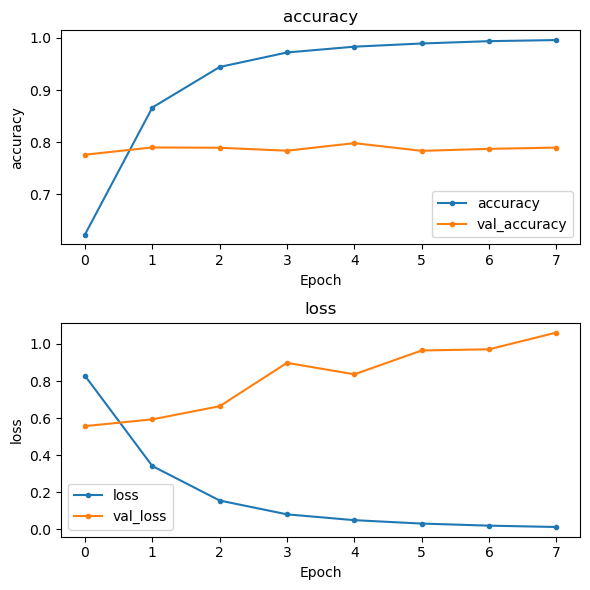


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3945
           1       1.00      1.00      1.00      3926
           2       1.00      1.00      1.00      3962

    accuracy                           1.00     11833
   macro avg       1.00      1.00      1.00     11833
weighted avg       1.00      1.00      1.00     11833



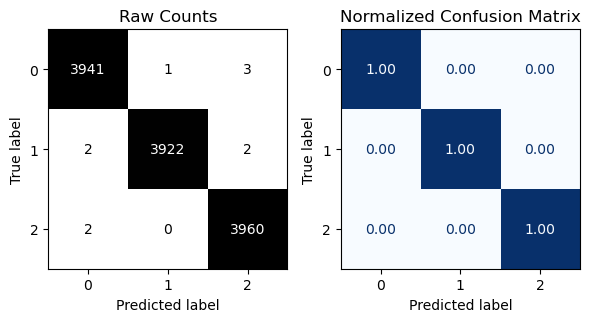


- Evaluating Training Data:
370/370 [==============================] - 4s 10ms/step - loss: 0.0040 - accuracy: 0.9992
{'loss': 0.0040380749851465225, 'accuracy': 0.9991549253463745}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       568
           1       0.87      0.80      0.83       576
           2       0.78      0.83      0.80       547

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



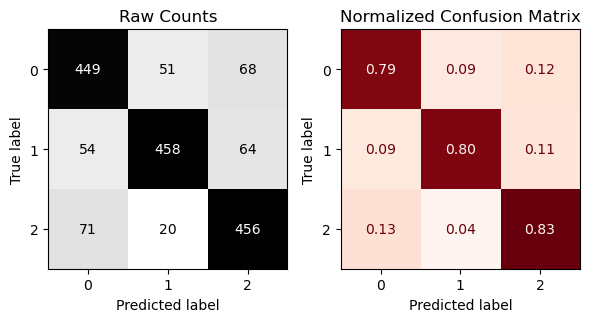


- Evaluating Test Data:
53/53 [==============================] - 1s 10ms/step - loss: 1.0025 - accuracy: 0.8060
{'loss': 1.0025423765182495, 'accuracy': 0.8060319423675537}


In [56]:
model = build_gru_model2(sequence_vectorizer)
# Fit the model
EPOCHS = 30
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
# Evaluate the model
results = evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

In [67]:
def build_stacked_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    EMBED_DIM = 150
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add GRU layer with 64 units, recurrent dropout =0.1 , and return sequences
    model.add(layers.GRU(128, recurrent_dropout=.2, dropout=.2, return_sequences = True))   
    
    ## Add a dropout layer set to 0.2
    model.add(layers.Dropout(.2))
    
    ## Add GRU layer with 64 units, recurrent dropout =0.1 , and do NOT return sequences
    model.add(layers.GRU(128, recurrent_dropout=.2, dropout=.2))
    model.add(layers.Dense(len(classes), 
                              activation='softmax'))
 
    # Compile the model
    model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
 
    model.summary()
    return model

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_16 (Embedding)    (None, 100, 150)          3125250   
                                                                 
 gru_20 (GRU)                (None, 100, 128)          107520    
                                                                 
 dropout_6 (Dropout)         (None, 100, 128)          0         
                                                                 
 gru_21 (GRU)                (None, 128)               99072     
                                                                 
 dense_15 (Dense)            (None, 3)                 387       
                                                     

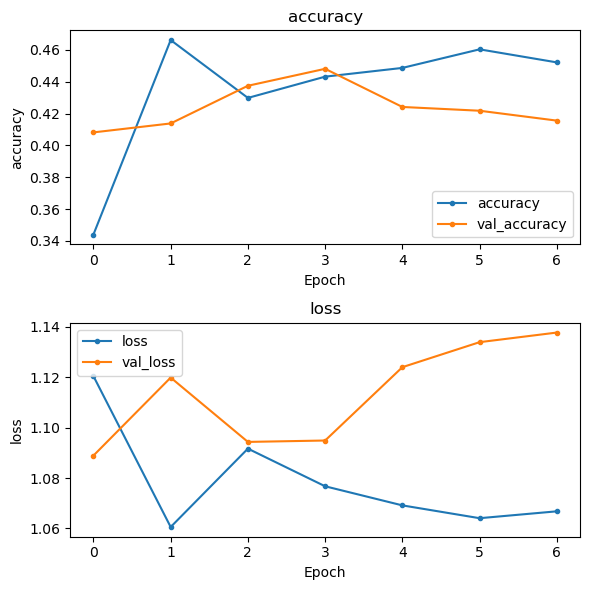


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3945
           1       1.00      1.00      1.00      3926
           2       1.00      1.00      1.00      3962

    accuracy                           1.00     11833
   macro avg       1.00      1.00      1.00     11833
weighted avg       1.00      1.00      1.00     11833



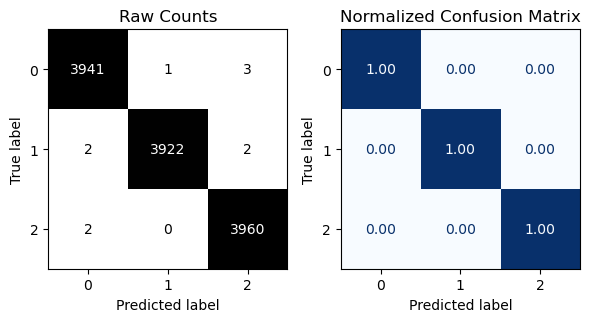


- Evaluating Training Data:
370/370 [==============================] - 5s 13ms/step - loss: 0.0040 - accuracy: 0.9992
{'loss': 0.0040380749851465225, 'accuracy': 0.9991549253463745}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.79      0.79       568
           1       0.87      0.80      0.83       576
           2       0.78      0.83      0.80       547

    accuracy                           0.81      1691
   macro avg       0.81      0.81      0.81      1691
weighted avg       0.81      0.81      0.81      1691



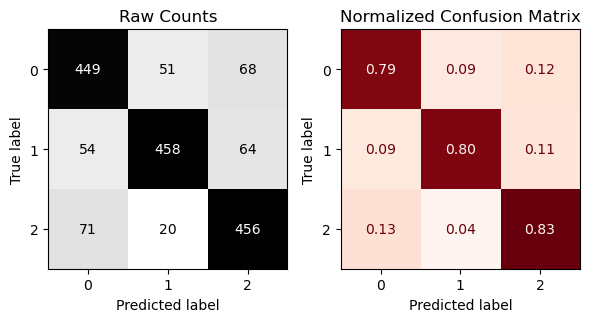


- Evaluating Test Data:
53/53 [==============================] - 1s 13ms/step - loss: 1.0025 - accuracy: 0.8060
{'loss': 1.0025423765182495, 'accuracy': 0.8060319423675537}


In [68]:
# Build the lstm model and specify the vectorizer
stacked_gru_model = build_stacked_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = stacked_gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks())

# Evaluate the model
results = evaluate_classification_network(
    model, X_train=train_ds, 
    X_test=test_ds, history=history);

- All 3 models performed very similar to each other. They all have 81% accuracy but the stacked rnn model has best precision and recall scores. I would consider this model moving foward. 